In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from mpl_toolkits.mplot3d import axes3d

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [4]:
from sample_3d_view import sample_sphere, sample_torus, visualize_grid_sphere, visualize_grid_torus, sample_ellipsoid

In [5]:
from local_pca_utils import make_nearest_neighbors_graph, make_tangents, make_2nd_order_laplacian,make_general_order_laplacian, make_connection

from curvature_utils import make_tangents_and_normals, get_second_fundamental_form

from tensorlaplacian_utils import get_riemannian_ricci_scalar, get_weitzenbock_operator, get_eigvals_of_weitzenbock, weitzenbock_to_bsr

In [254]:
npoints = 1700

In [255]:
ind = np.arange(0,10,1)
np.random.shuffle(ind)

In [256]:
ind

array([6, 1, 7, 4, 8, 9, 5, 0, 2, 3])

In [257]:
data = np.loadtxt('bunny3.txt')
data = data[:, [0, 2, 1]]
data *= 10
np.random.shuffle(data)
data = data[:npoints]
npoints = data.shape[0]
graph = make_nearest_neighbors_graph(data, 6, n=npoints)


#s2_tangents, s2_normals, local_coords, s2triu, s2_h = get_second_fundamental_form(data_s2, s2_graph, 2)
_,_,_,_, h = get_second_fundamental_form(data, graph, 2)

Riem, Ric, Scal = get_riemannian_ricci_scalar(h)
origin = data

100%|██████████| 1700/1700 [00:00<00:00, 3797.40it/s]


In [258]:
weitzenbock = get_weitzenbock_operator(Riem,2,1)
block_weitzenbock = weitzenbock_to_bsr(weitzenbock)

In [259]:
block_weitzenbock

<3400x3400 sparse matrix of type '<class 'numpy.float64'>'
	with 6800 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [260]:
tangents = make_tangents(data, graph, 2)

connection = make_connection(tangents, graph)

s_1st_order_lap = make_general_order_laplacian(connection, graph, 1, sym=False, zero_trace=False)

#s_2nd_order_lap = make_2nd_order_laplacian(connection, s2_graph, sym=False, zero_trace=False)

100%|██████████| 1700/1700 [00:00<00:00, 14484.48it/s]


In [261]:
lichnerowicz = -s_1st_order_lap + block_weitzenbock

In [ ]:
eigvals, eigvecs = scipy.sparse.linalg.eigs(lichnerowicz, k=4, which='SM')

In [216]:
eigvals

array([-0.14768511+0.j, -0.1473487 +0.j, -0.19493007+0.j, -0.19571208+0.j])

In [217]:
eigvecs.shape

(3000, 4)

In [218]:
eigvecs[:,0].shape

(3000,)

In [239]:
eigvector = eigvecs[:,3].real

In [240]:
eigvector.real

array([ 4.65625217e-03, -7.83591125e-03, -7.19880685e-05, ...,
       -8.69577913e-04,  6.28896382e-03,  5.82258751e-02])

In [241]:
eigvector = eigvector.reshape(-1,2)

In [242]:
eigvector

array([[ 4.65625217e-03, -7.83591125e-03],
       [-7.19880685e-05,  9.16316338e-05],
       [-1.49239938e-02, -1.15842522e-02],
       ...,
       [ 9.12478833e-05,  3.92477322e-04],
       [-5.09879447e-04, -8.69577913e-04],
       [ 6.28896382e-03,  5.82258751e-02]])

In [243]:
tangents.shape

(1500, 2, 3)

In [244]:
eigvector.shape

(1500, 2)

In [245]:
killingfield = np.zeros((npoints, 3))

In [246]:
for i in range(npoints):
    killingfield[i] = tangents[i, 0]* eigvector[i, 0] +  tangents[i, 1]* eigvector[i, 1] 

In [247]:
killingfield.shape

(1500, 3)

In [248]:
visualizer = np.zeros((npoints, 6))

In [249]:
data.shape

(35947, 3)

In [250]:
indices = np.where(np.logical_not((data[:,0]<0)&(data[:,1]>0)))

In [251]:
visualizer[:,:3] = origin
visualizer[:,3:] = killingfield*15

In [252]:
X, Y, Z, U, V, W = zip(*visualizer[:])

In [191]:
data = np.loadtxt('bunny2.txt')
#data = data[:, [0, 2, 1]]
data *= 10
np.random.shuffle(data)
graph = make_nearest_neighbors_graph(data, 60, n=35947)
_,_,_,_, true_h = get_second_fundamental_form(data, graph, 2)
riem, ric, sc = get_riemannian_ricci_scalar(true_h)

100%|██████████| 35947/35947 [00:09<00:00, 3628.81it/s]


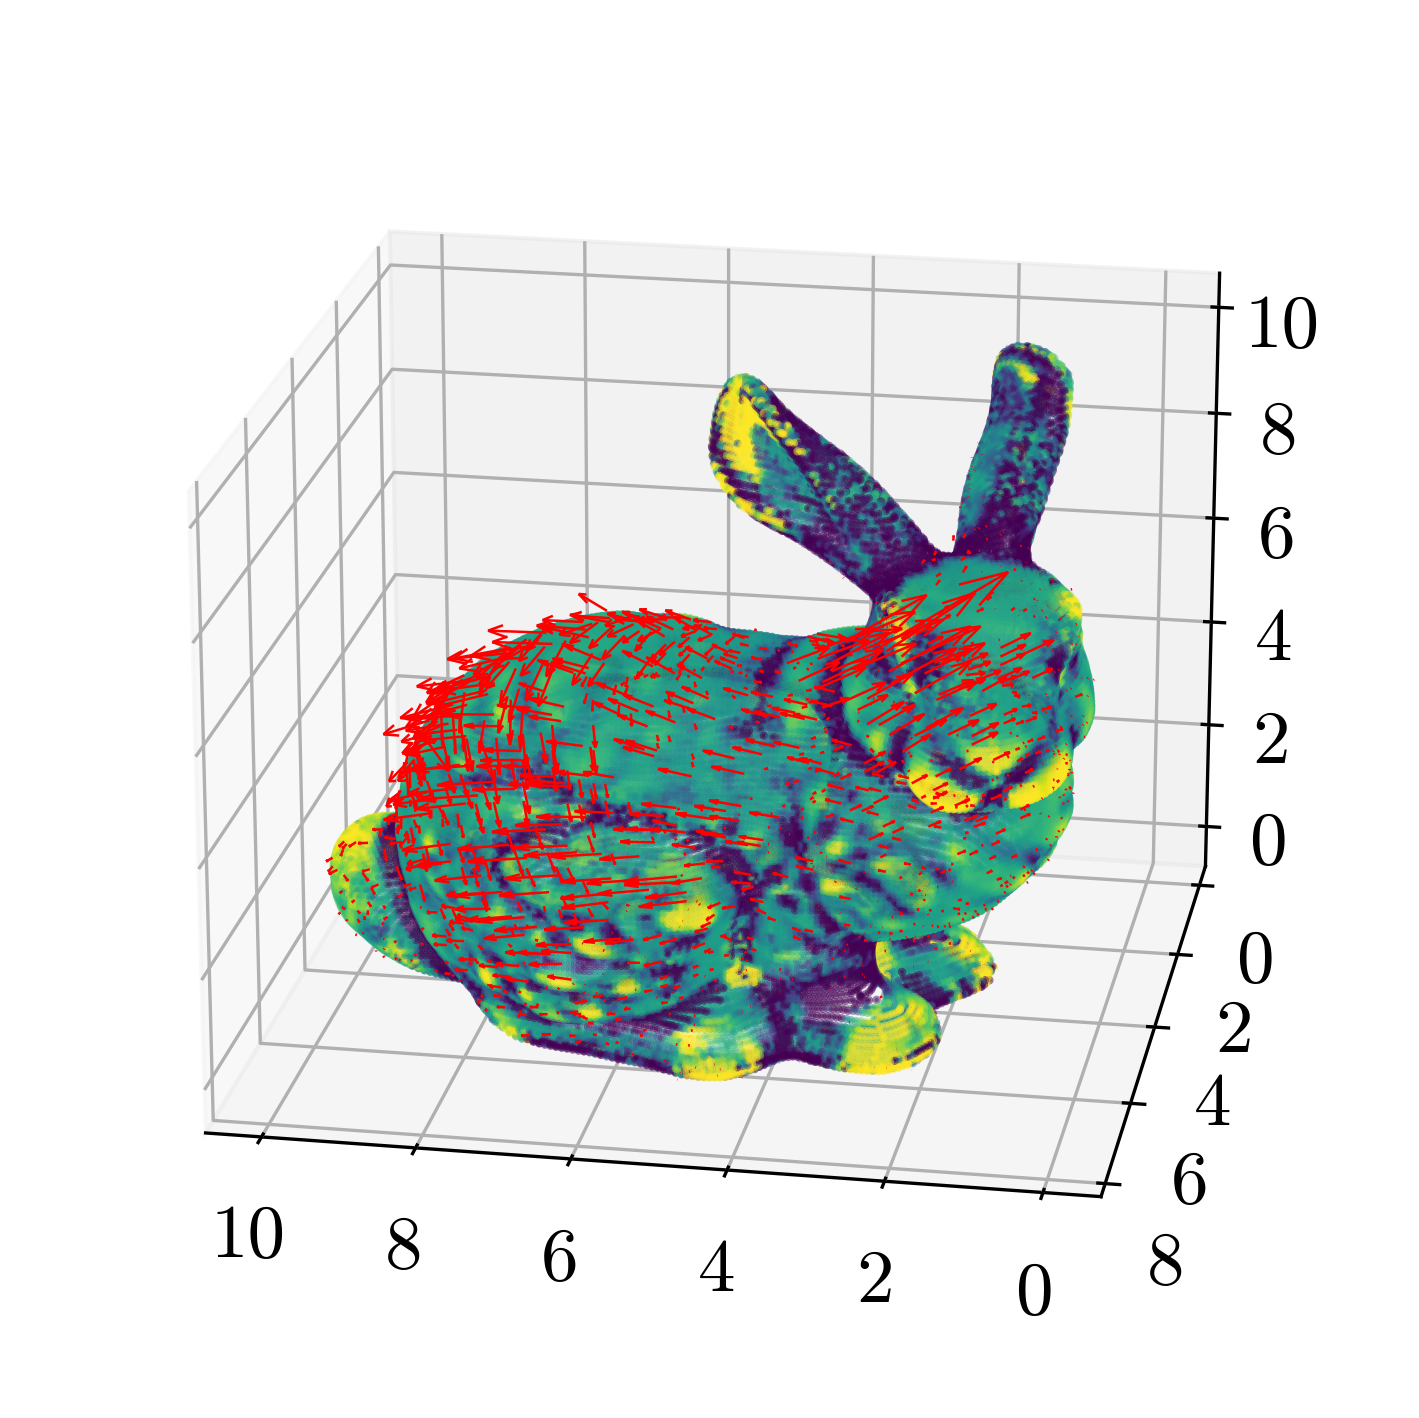

In [253]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.set_box_aspect([2,2,1])
#fig, ax = visualize_grid_torus(30,2,1)
#ax.scatter(data[:,0], data[:, 1], data[:,2], s=1, c=sc, cmap='viridis',zorder=10, alpha=0.5)
ax.scatter(data[:,0], data[:, 2], data[:,1], s=1, c=sc, cmap='viridis',zorder=10,norm = mpl.colors.Normalize(vmin=-1, vmax=.8, clip=False), alpha=0.5)
#ax.view_init(20, 40)
ax.view_init(20, 100)
ax.quiver(X, Y, Z, U, V, W, color="r", linewidth=0.6)

In [214]:
fig.savefig(f'../figures/KillingField_Bunny_best.png')    
fig.savefig(f'../figures/KillingField_Bunny_best.pdf')

In [118]:
ax.quiver(X, Y, Z, U, V, W, color="C0", linewidth=0.6)

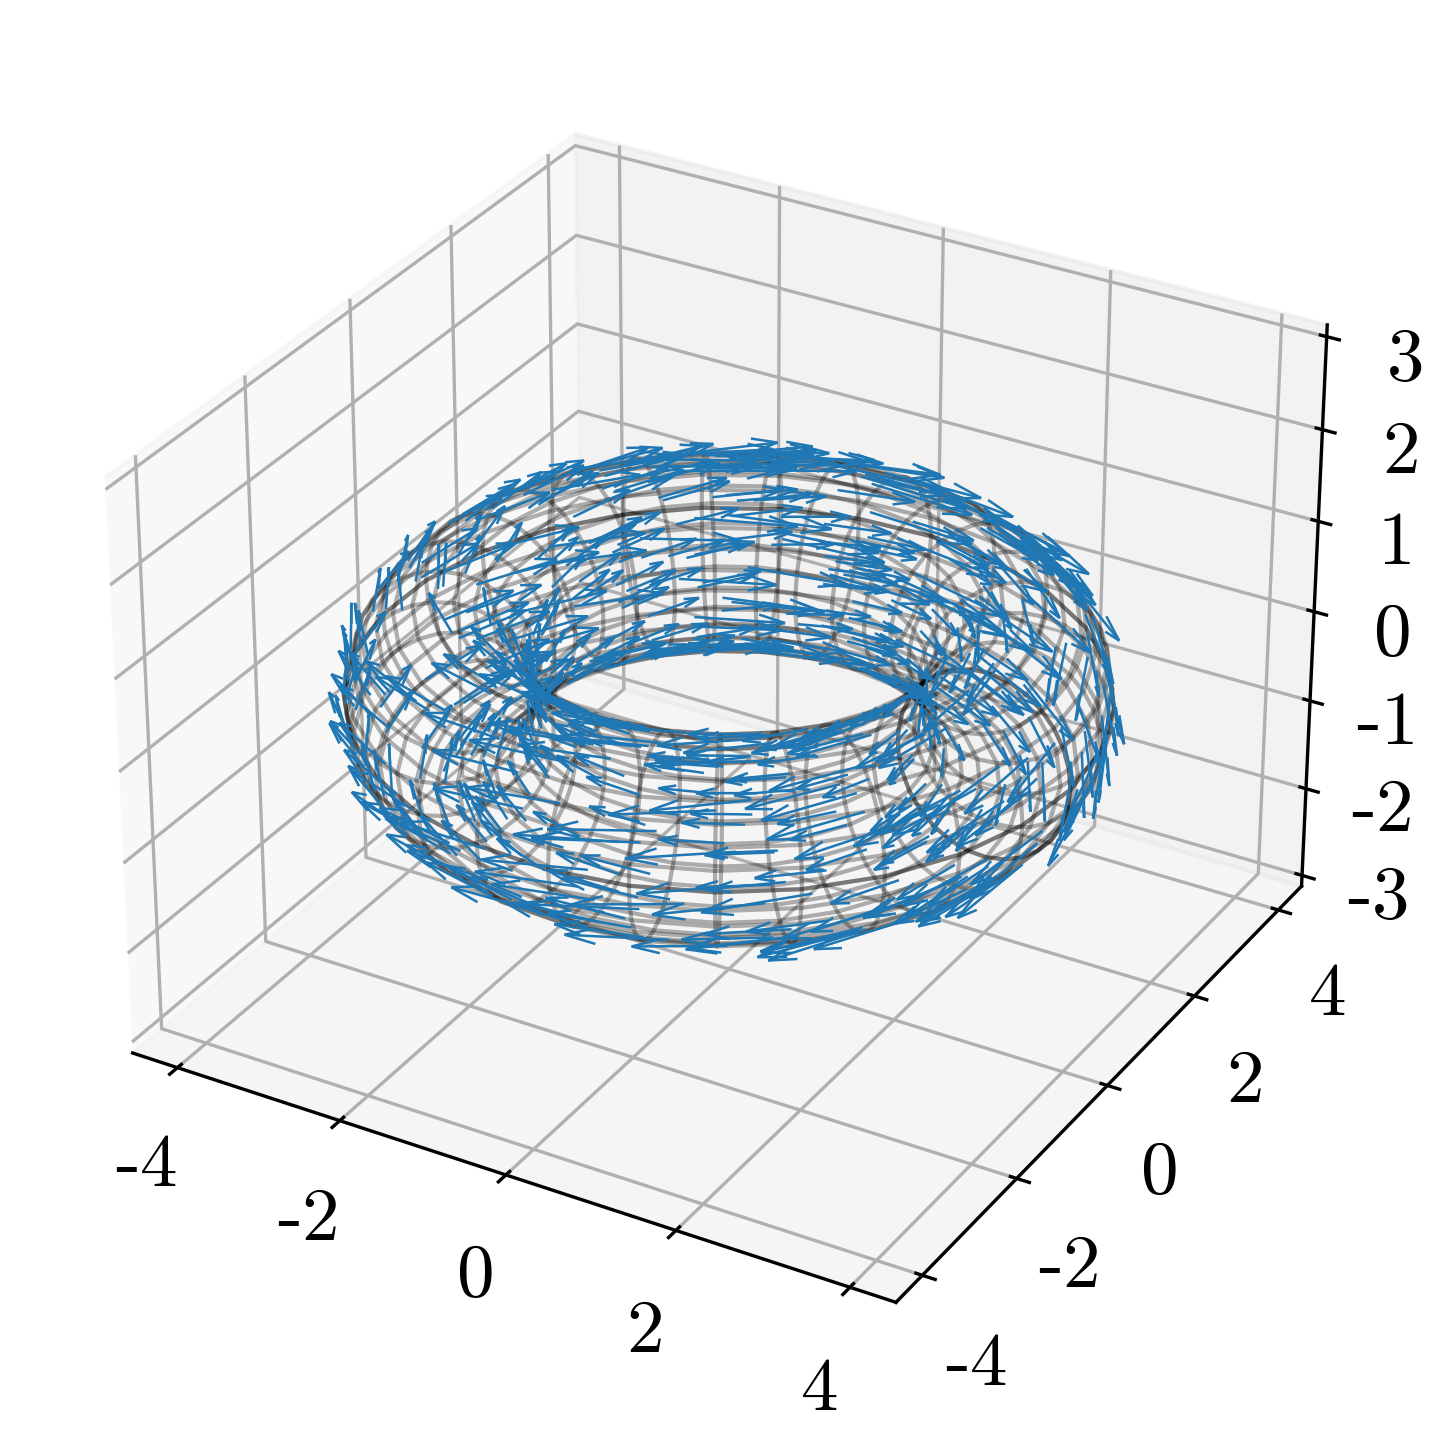

In [119]:
fig

In [120]:
fig.savefig(f'../figures/KillingField_Torus_first.png')    
fig.savefig(f'../figures/KillingField_Torus_first.pdf')